In [43]:
import pandas as pd
import numpy as np
from sklearn.ensemble import AdaBoostClassifier
from tensorflow.keras.datasets import fashion_mnist
from sklearn.naive_bayes import GaussianNB
from sklearn.model_selection import KFold
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.model_selection import cross_val_score
from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.cluster import KMeans
from sklearn import metrics
from sklearn.svm import SVC
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten
from tensorflow.keras.datasets import fashion_mnist
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.utils import to_categorical
import seaborn as sn

In [2]:
((trainX, trainY), (testX, testY)) = fashion_mnist.load_data()
trainX[:2]

array([[[0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        ...,
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0]],

       [[0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        ...,
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0]]], dtype=uint8)

### Labels
Each training and test example is assigned to one of the following labels:

| Label | Description |
| --- | --- |
| 0 | T-shirt/top |
| 1 | Trouser |
| 2 | Pullover |
| 3 | Dress |
| 4 | Coat |
| 5 | Sandal |
| 6 | Shirt |
| 7 | Sneaker |
| 8 | Bag |
| 9 | Ankle boot |


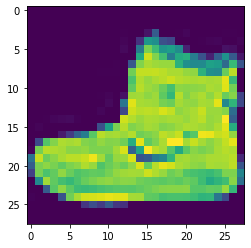

In [3]:
plt.imshow(trainX[0])
plt.show()

In [4]:
print(trainX.shape)
trainX = trainX.reshape(len(trainX),28*28)
print(trainX.shape)
testX = testX.reshape(len(testX),28*28)

(60000, 28, 28)
(60000, 784)


In [5]:
pca = PCA(n_components=0.95)
pca.fit(trainX)
compressed_trainX = pca.transform(trainX)
decompressed_trainX = pca.inverse_transform(compressed_trainX)
compressed_testX = pca.transform(testX)
decompressed_testX = pca.inverse_transform(compressed_testX)

new shape: (60000, 784)


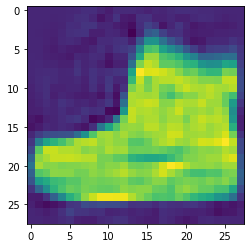

In [6]:
print("new shape:",trainX.shape)
plt.imshow(decompressed_trainX[0].reshape(28,28))
plt.show()

In [7]:
def validate(model):
    model.fit(compressed_trainX, trainY)
    y_pred = model.predict(compressed_trainX)
    scores = cross_val_score(model,compressed_testX, testY, cv=10)
    return(scores.mean())

In [8]:
naive_bayes_model = GaussianNB()
print(validate(naive_bayes_model))

0.7333999999999999


In [41]:
svc=SVC(probability=True, kernel='linear')
adaboost_model=AdaBoostClassifier(n_estimators=50)
print(validate(adaboost_model))

0.48240000000000005


In [15]:
rnd_clf = RandomForestClassifier(n_estimators=500, max_leaf_nodes=16, n_jobs=-1)
print(validate(rnd_clf))

0.7593


In [28]:
kmeans = KMeans(n_clusters=256, random_state=0).fit(compressed_trainX)

def infer_data_labels(X_labels, cluster_labels):
    predicted_labels = np.zeros(len(X_labels)).astype(np.uint8)
    for i, cluster in enumerate(X_labels):
        for key, value in cluster_labels.items():
            if cluster in value:
                predicted_labels[i] = key
    return predicted_labels

In [39]:
def infer_cluster_labels(kmeans, actual_labels):
    inferred_labels = {}
    for i in range(kmeans.n_clusters):
        labels = []
        index = np.where(kmeans.labels_ == i)
        labels.append(actual_labels[index])
        if len(labels[0]) == 1:
            counts = np.bincount(labels[0])#count the occurrence
        else:
            counts = np.bincount(np.squeeze(labels))
        if np.argmax(counts) in inferred_labels:
            inferred_labels[np.argmax(counts)].append(i)
        else:
            inferred_labels[np.argmax(counts)] = [i]
    return inferred_labels

In [40]:
cluster_labels = infer_cluster_labels(kmeans, trainY)
X_clusters = kmeans.predict(compressed_testX)
predicted_labels = infer_data_labels(X_clusters, cluster_labels)
metrics.accuracy_score(testY, predicted_labels)

0.7783

In [55]:
x_train = trainX.reshape(trainX.shape[0], -1) / 255.0
x_test = testX.reshape(testX.shape[0], -1) / 255.0
y_train = to_categorical(trainY)
y_test = to_categorical(testY)

In [56]:
model = Sequential()

model.add(Dense(10, input_dim=784, activation='relu'))#hidden layer
model.add(Dense(50, activation='relu'))
model.add(Dense(10, activation='softmax'))#output layer, Softmax - more than two categories,(Sigmoid - two categories)

model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
#loss(multi-categories=categorical_crossentropy, two-categories=binary_crossentropy),optimizer(adam or rmsprop)

In [57]:
model.fit(x_train, y_train, epochs=10, validation_split=0.1)
_, test_acc = model.evaluate(x_test, y_test)
print(test_acc)

Epoch 1/10
1688/1688 [==============================] - 3s 2ms/step - loss: 0.6469 - accuracy: 0.7694 - val_loss: 0.4826 - val_accuracy: 0.8298
Epoch 2/10
1688/1688 [==============================] - 3s 2ms/step - loss: 0.4560 - accuracy: 0.8403 - val_loss: 0.4312 - val_accuracy: 0.8462
Epoch 3/10
1688/1688 [==============================] - 3s 2ms/step - loss: 0.4196 - accuracy: 0.8505 - val_loss: 0.4142 - val_accuracy: 0.8503
Epoch 4/10
1688/1688 [==============================] - 3s 2ms/step - loss: 0.3999 - accuracy: 0.8545 - val_loss: 0.4085 - val_accuracy: 0.8507
Epoch 5/10
1688/1688 [==============================] - 3s 2ms/step - loss: 0.3879 - accuracy: 0.8584 - val_loss: 0.3933 - val_accuracy: 0.8570
Epoch 6/10
1688/1688 [==============================] - 2s 1ms/step - loss: 0.3754 - accuracy: 0.8632 - val_loss: 0.4103 - val_accuracy: 0.8488
Epoch 7/10
1688/1688 [==============================] - 3s 2ms/step - loss: 0.3683 - accuracy: 0.8654 - val_loss: 0.3886 - val_accuracy:

In [61]:
((trainX, trainY), (testX, testY)) = fashion_mnist.load_data()
x_train = trainX[:,:,:,np.newaxis] / 255.0
x_test = testX[:,:,:,np.newaxis] / 255.0

In [62]:
model4 = Sequential()
model4.add(Conv2D(filters=64, kernel_size=2, padding='same', activation='relu', input_shape=(28,28, 1))) 
model4.add(MaxPooling2D(pool_size=2))
model4.add(Flatten())
model4.add(Dense(10, activation='softmax'))
model4.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

In [63]:
model4.summary()
model4.fit(x_train, y_train, epochs=10, validation_split=0.1)
_, test_acc = model4.evaluate(x_test, y_test)
print(test_acc)

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 28, 28, 64)        320       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 14, 14, 64)        0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 12544)             0         
_________________________________________________________________
dense_10 (Dense)             (None, 10)                125450    
Total params: 125,770
Trainable params: 125,770
Non-trainable params: 0
_________________________________________________________________
Epoch 1/10
1688/1688 [==============================] - 52s 31ms/step - loss: 0.4316 - accuracy: 0.8513 - val_loss: 0.3379 - val_accuracy: 0.8787
Epoch 2/10
1688/1688 [==============================] - 48s 28ms/step - loss: 0.3101 - accuracy: 0.8